<a href="https://colab.research.google.com/github/amelia2801/CS598-DLH-Team56/blob/main/DL4H_Team_56.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is the CS 598 Deep Learning for Healthcare Final Project. All other supplementary files and the notebook itself can be accessed from this Google Drive link: https://drive.google.com/drive/folders/1zt1xwsVEDUSJVlgYPBxmAcfsWkehpo9G?usp=drive_link

*For Final Project submission purpose, a public GitHub repository containing the notebook also available: https://github.com/amelia2801/CS598-DLH-Team56/

A presentation video about this project is available here: https://mediaspace.illinois.edu/media/t/1_fq8jk4ss

# Introduction

Family history is a proven indicator of an individual's predisposition to certain diseases, but its use is complicated by the difficulty of gathering family history data and the lack of tools to intepret such data and connections. The introduction and prevalence of EHRs has made patient medical information much easier to access and compile across generations, presenting an opportunity to study multigenerational EHRs for entire families. Meanwhile, machine learning techniques have improved to the point where not only processing large amounts of medical data but also interpreting family connections between individuals is possible.

There are some existing works that also includes family history in machine learning models to predict the risk of various diseases [3,4]. However, their approaches were developed for tabular data. Thus, they do not model the geometric structure of family history which is useful for the prediction.

The paper aims to demonstrate the effectiveness of graph-based learning in predicting disease onset in individuals based off of their family history. To do this, the authors used graph neural networks (GNNs) and Long Short-Term Memory networks (LSTMs).

The model proposed by the paper learns explainable node embeddings for individual relatives and also achieves better performance for complex diseases than clinically-inspired and other deep learning baselines.

# Scope of Reproducibility:


Here we list the hypotheses from the paper that we will test and the experiment that we will run.


**Hypothesis**: A graph-based approach to predicting disease through family history is better compared to other current deep-learning approaches.

In this notebook, we will run a part of ablation studies that was done by the paper, specifically using the synthetic datasets provided by the authors. The proposed model GNN-LSTM are compared to several others deep learning baselines.

We imported some the code provided by the authors of the paper from [2] into this notebook.

# Methodology

In [ ]:
# Uninstall any torch installation if exists. This is to make sure that we import the correct version.
!pip uninstall torch -y

Found existing installation: torch 2.2.1+cu121
Uninstalling torch-2.2.1+cu121:
  Successfully uninstalled torch-2.2.1+cu121


Mount the notebook to Google Drive with the specified directory:

In [ ]:
import sys
print(f"sys version: {sys.version}")
from google.colab import drive

# Mount notebook to google drive
drive.mount('/content/gdrive', force_remount=True)
root_url = '/content/gdrive/My Drive/CS598 DLH Project'
sys.path.append(root_url)


sys version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Mounted at /content/gdrive


❗ FOR GRADER: Run the cell below only once, the first time you run this notebook. This will install necessary libraries once.

In [ ]:
# Install virtualenv to create virtual environment
!pip install virtualenv
# Create virtual environment
!virtualenv '/content/gdrive/My Drive/CS598 DLH Project/colab_env'
# Activate the virtual environment and install necessary libraries
# Here we install: torch 1.12.1, torchvision 0.13.1, torchaudio 0.12.1, torch-geometric 2.2.0
!source /content/gdrive/My\ Drive/CS598\ DLH\ Project/colab_env/bin/activate; pip install torch==1.12.1+cu102 torchvision==0.13.1+cu102 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu102; pip install pyg-lib torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-1.12.0+cu102.html; pip install torch_geometric==2.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 13.3 MB/s eta 0:00:00
created virtual environment CPython3.10.12.final.0-64 in 31881ms
  creator CPython3Posix(dest=/content/gdrive/.shortcut-targets-by-id/1zt1xwsVEDUSJVlgYPBxmAcfsWkehpo9G/CS598 DLH Project/colab_env, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: Jinja2==3.1.3, MarkupSafe==2.1.5, certifi==2024.2.2, charset_normalizer==3.3.2, idna==3.7, joblib==1.4.0, numpy==1.26.4, pillow==10.3.0, pip==24.0, psutil==5.9.8, pyg_lib==0.2.0+pt112cu102, pyparsing==3.1.2, requests==2.31.0, scikit_learn==1.4.2, scipy==1.13.0, setuptools==69.5.1, threadpoolctl==3.4.0, torch==1.12.1+cu102, torch_cluster==1.6.3, torch_geometric==2.2.0, torch_scatter==2.1.2, torch_sparse==0.6.18, torchaudio==0.12.

In [ ]:
# Append the path of installed packages
sys.path.append("/content/gdrive/My Drive/CS598 DLH Project/colab_env/lib/python3.10/site-packages")

In [ ]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/gdrive/My Drive/CS598 DLH Project',
 '/content/gdrive/My Drive/CS598 DLH Project/colab_env/lib/python3.10/site-packages']

In [ ]:
# Activate the virtual environment
!source /content/gdrive/My\ Drive/CS598\ DLH\ Project/colab_env/bin/activate;

In [ ]:
import time
import numpy as np
import torch
print(f"pytorch version: {torch.__version__}")
import torch.nn as nn
from torch.utils.data import Dataset

import torch_geometric
print(f"torch_geometric version: {torch_geometric.__version__}")
import torch_geometric.nn as gnn
from torch_geometric.data import Dataset as GraphDataset
from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader

import torch.nn.functional as F
import pandas as pd
from random import choices
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix

pytorch version: 1.12.1+cu102
torch_geometric version: 2.2.0


In [ ]:
from utils import EarlyStopping, get_classification_threshold_auc, get_classification_threshold_precision_recall, WeightedBCELoss
import explainability

##  Data

The original paper used data from Finland's nationwide EHR system, which we are unable to use for privacy and security reasons. Instead, we will use the example synthetic dataset they generated from the provided synthetic data generator, which we store in the folder 'sample_data'. The example data can also be found here: https://github.com/dsgelab/family-EHR-graphs/tree/main/test.

The dataset consists of 3 main files - the edgefile, maskfile, and statfile - and several feature files that specifies which features to use for training the model. The maskfile contains data that specifies which samples belong to the target cohort - the patients to predict outcomes for - and which samples belong to the family cohort - relatives of the target patients, as well as specifying the training, validation, and test split for the dataset. The edgefile contains data for the edges and edge pairs for the family graphs. The statfile contains the age, sex, medical history data, and prediction label for all samples.

In [ ]:
class DataFetch():
    '''
    Class to fetch and format data
    '''
    def __init__(self, maskfile, featfile, statfile, edgefile, sqlpath, params, alt_featfile=None, local=False):
        feat_df = pd.read_csv(featfile)
        self.local = local
        self.static_features = feat_df[feat_df['type']=='static']['name'].tolist()
        self.longitudinal_features = feat_df[feat_df['type']=='longitudinal']['name'].tolist()
        self.edge_features = feat_df[feat_df['type']=='edge']['name'].tolist()
        # some gnn layers only support a single edge weight
        if params['gnn_layer'] in ['gcn', 'graphconv']: self.edge_features=['weight']
        self.label_key = feat_df[feat_df['type']=='label']['name'].tolist()[0]
        self.static_data = torch.tensor(pd.read_csv(statfile)[self.static_features].values, dtype=torch.float)
        self.label_data = torch.tensor(pd.read_csv(statfile)[self.label_key].to_numpy(), dtype=torch.float32)
        if len(self.longitudinal_features)>0 and not self.local: self.conn = sqlite3.connect(sqlpath)
        self.params = params

        if params['model_type'] in ['graph', 'graph_no_target', 'explainability']:
            # can specify a different feature set using alt_featfile
            alt_feat_df = pd.read_csv(alt_featfile)
            self.alt_static_features = alt_feat_df[alt_feat_df['type']=='static']['name'].tolist()
            self.alt_static_data = torch.tensor(pd.read_csv(statfile)[self.alt_static_features].values, dtype=torch.float)

        mask_df = pd.read_csv(maskfile)
        self.id_map = dict(zip(mask_df['node_id'], mask_df['PATIENTID']))
        self.train_patient_list = torch.tensor(mask_df[mask_df['train']==0]['node_id'].to_numpy())
        self.validate_patient_list = torch.tensor(mask_df[mask_df['train']==1]['node_id'].to_numpy())
        self.test_patient_list = torch.tensor(mask_df[mask_df['train']==2]['node_id'].to_numpy())
        self.num_samples_train_minority_class = torch.sum(self.label_data[self.train_patient_list]==1).item()
        self.num_samples_train_majority_class = torch.sum(self.label_data[self.train_patient_list]==0).item()
        self.num_samples_valid_minority_class = torch.sum(self.label_data[self.validate_patient_list]==1).item()
        self.num_samples_valid_majority_class = torch.sum(self.label_data[self.validate_patient_list]==0).item()

        if params['model_type']!='baseline':
            self.edge_df = pd.read_csv(edgefile)
            self.edge_df = self.edge_df.groupby('target_patient').agg(list)

    def get_static_data(self, patients):
        x_static = self.static_data[patients]
        y = self.label_data[patients]
        return x_static, y

    def get_alt_static_data(self, patients):
        x_static = self.alt_static_data[patients]
        return x_static

    def get_longitudinal_data(self, patients):
        if self.local:
            # return simulated data for local testing
            num_nodes = len(patients)
            num_years = self.params['obs_window_end']-self.params['obs_window_start']+1
            num_features = len(self.longitudinal_features)
            num_data = int(num_nodes*num_years*num_features*0.01)
            i = [choices(range(num_nodes),k=num_data), choices(range(num_years),k=num_data), choices(range(num_features),k=num_data)]
            v = [1]*num_data
            x_longitudinal = torch.sparse_coo_tensor(i, v, (num_nodes, num_years, num_features), dtype=torch.float32)
            x_longitudinal_dense = x_longitudinal.to_dense()
        else:
            # fetch data from SQLite database
            id_list = [self.id_map[patient.item()] for patient in patients]
            data = pd.DataFrame()
            for patient in id_list:
                command = "SELECT PATIENTID, EVENT_YEAR, ENDPOINT FROM long WHERE PATIENTID='{}'".format(patient)
                data = pd.concat([data, pd.read_sql_query(command, self.conn)])
            data = data[data['ENDPOINT'].isin(self.longitudinal_features)]

            # limit to observation window years
            data['EVENT_YEAR'] = data['EVENT_YEAR'].astype(int)
            data = data[(data['EVENT_YEAR']>=self.params['obs_window_start'])&(data['EVENT_YEAR']<=self.params['obs_window_end'])]

            # map to index positions
            node_index = dict(zip(id_list, range(len(id_list))))
            year_index = dict(zip(np.arange(self.params['obs_window_start'], self.params['obs_window_end']+1), range(self.params['obs_window_end']-self.params['obs_window_start']+1)))
            feat_index = dict(zip(self.longitudinal_features, range(len(self.longitudinal_features))))
            data['PATIENTID'] = data['PATIENTID'].map(node_index)
            data['EVENT_YEAR'] = data['EVENT_YEAR'].map(year_index)
            data['ENDPOINT'] = data['ENDPOINT'].map(feat_index)

            # create sparse tensor
            i = [data['PATIENTID'].tolist(), data['EVENT_YEAR'].tolist(), data['ENDPOINT'].tolist()]
            v = [1]*len(data)
            x_longitudinal = torch.sparse_coo_tensor(i, v, (len(node_index), len(year_index), len(feat_index)), dtype=torch.float32)
            x_longitudinal_dense = x_longitudinal.to_dense()

        return x_longitudinal_dense

    def get_relatives(self, patients):
        """Returns a list of node ids included in any of these patient graphs
        """
        return torch.tensor(list(set([i for list in self.edge_df.loc[patients]['node1'].to_list() for i in list] + [i for list in self.edge_df.loc[patients]['node2'].to_list() for i in list])))

    def construct_patient_graph(self, patient, all_relatives, all_x_static, all_y, all_x_longitudinal=None):
        """Creates a re-indexed pytorch geometric data object for the patient
        """
        # order nodes and get indices in all_relatives to retrieve feature data
        node_ordering = np.asarray(list(set(self.edge_df.loc[patient].node1 + self.edge_df.loc[patient].node2)))
        node_indices = [list(all_relatives.tolist()).index(value) for value in node_ordering]
        x_static = all_x_static[node_indices]
        y = all_y[list(all_relatives.tolist()).index(patient)] # predicting single value for each graph

        # reindex the edge indices from 0, 1, ... num_nodes
        node1 = [list(node_ordering.tolist()).index(value) for value in self.edge_df.loc[patient].node1]
        node2 = [list(node_ordering.tolist()).index(value) for value in self.edge_df.loc[patient].node2]
        edge_index = torch.tensor([node1,node2], dtype=torch.long)
        edge_weight = torch.t(torch.tensor(self.edge_df.loc[patient][self.edge_features], dtype=torch.float))

        data = torch_geometric.data.Data(x=x_static, edge_index=edge_index, y=y, edge_attr=edge_weight)
        transform = torch_geometric.transforms.ToUndirected(reduce='mean')
        data = transform(data)
        if all_x_longitudinal is not None: data.x_longitudinal = all_x_longitudinal[node_indices]
        data.target_index = torch.tensor(list(node_ordering.tolist()).index(patient))
        return data


class Data(Dataset):
    def __init__(self, patient_list, fetch_data):
        """
        Loads non-graph datasets for a given list of patients
        Returns (x_static, x_longitudinal, y) if longitudinal data included, else (x_static, y)
        """
        self.patient_list = patient_list
        self.num_target_patients = len(patient_list)
        self.fetch_data = fetch_data
        self.include_longitudinal = len(fetch_data.longitudinal_features)>0

    def __getitem__(self, patients):
        batch_patient_list = self.patient_list[patients]
        x_static, y = self.fetch_data.get_static_data(batch_patient_list)
        if self.include_longitudinal:
            x_longitudinal = self.fetch_data.get_longitudinal_data(batch_patient_list)
            return x_static, x_longitudinal, y
        else:
            return x_static, y

    def __len__(self):
        return self.num_target_patients


class GraphData(GraphDataset):
  def __init__(self, patient_list, fetch_data):
      """
      Loads a batch of multiple patient graphs
      """
      self.patient_list = patient_list
      self.num_target_patients = len(patient_list)
      self.fetch_data = fetch_data
      self.include_longitudinal = len(fetch_data.longitudinal_features)>0

  def __getitem__(self, patients):
      # returns multiple patient graphs by constructing a pytorch geometric Batch object
      batch_patient_list = self.patient_list[patients]
      data_list = []

      # it's more efficient to fetch feature data for all patients and their relatives,
      # and then split into separate graphs
      all_relatives = self.fetch_data.get_relatives(batch_patient_list)
      all_x_static, all_y = self.fetch_data.get_static_data(all_relatives)
      patient_x_static = self.fetch_data.get_alt_static_data(batch_patient_list)
      if self.include_longitudinal: all_x_longitudinal = self.fetch_data.get_longitudinal_data(all_relatives)
      else: all_x_longitudinal = None

      patient_index = 0
      for patient in batch_patient_list:
        patient_graph = self.fetch_data.construct_patient_graph(patient.item(), all_relatives, all_x_static, all_y, all_x_longitudinal)
        patient_graph.patient_x_static = patient_x_static[patient_index].reshape(1,-1)
        if self.include_longitudinal:
            patient_x_longitudinal = patient_graph.x_longitudinal[patient_graph.target_index]
            patient_graph.patient_x_longitudinal = patient_x_longitudinal[None,:,:]
        data_list.append(patient_graph)
        patient_index += 1

      batch_data = Batch.from_data_list(data_list)
      return batch_data

  def __len__(self):
      return self.num_target_patients

In [ ]:
def get_data_and_loader(patient_list, fetch_data, params, shuffle=True):
    """
    Parameters:
    patient_list: list of patients (target samples) to load data for
    fetch_data: the data object
    params: dictionary of other parameters
    shuffle: samples in random order if true
    """
    if params['model_type'] == 'baseline':
        dataset = Data(patient_list, fetch_data)
    elif params['model_type'] in ['graph', 'graph_no_target', 'explainability']:
        dataset = GraphData(patient_list, fetch_data)

    if shuffle:
        sample_order = torch.utils.data.sampler.RandomSampler(dataset)
    else:
        sample_order = torch.utils.data.sampler.SequentialSampler(dataset)

    sampler = torch.utils.data.sampler.BatchSampler(
        sample_order,
        batch_size=params['batchsize'],
        drop_last=False)

    loader = DataLoader(dataset, sampler=sampler, num_workers=params['num_workers'])
    return dataset, loader

In [ ]:
raw_data_dir = root_url +'/sample_data'
edgefile = raw_data_dir + '/Gen3_50k_0.7_142857_edgefile.csv'
maskfile = raw_data_dir + '/Gen3_50k_0.7_142857_maskfile.csv'
statfile = raw_data_dir + '/Gen3_50k_0.7_142857_statfile.csv'
featfile_A2 = raw_data_dir + '/featfiles/featfile_A2.csv'
featfile_A5 = raw_data_dir + '/featfiles/featfile_A5.csv'
featfile_G1 = raw_data_dir + '/featfiles/featfile_G1.csv'
featfile_G2 = raw_data_dir + '/featfiles/featfile_G2.csv'

# params for G2
params = {'model_type':'explainability',
          'gnn_layer':'graphconv',
          'pooling_method':'target',
          'obs_window_start':1990,
          'obs_window_end':2010,
          'num_workers':1,
          'batchsize':250,
          'max_epochs':5, # default is 100
          'patience':5,
          'learning_rate':0.001,
          'main_hidden_dim':20,
          'lstm_hidden_dim':20,
          'gamma':1,
          'alpha':1,
          'beta':1,
          'delta':1,
          'dropout_rate':0.5}

# Will use GPU if available by default, change the value to cpu if you don't want this
params['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using {} device".format(params['device']))

# Data, train set, validate set, test set for G2:

# To run the Explainability Analysis, we need to use this setup:
# featfile=test/featfiles/featfile_G2.csv # for family
# alt_featfile=test/featfiles/featfile_A5.csv # for target

fetch_data = DataFetch(
    maskfile=maskfile,
    featfile=featfile_G2,
    statfile=statfile,
    edgefile=edgefile,
    sqlpath=None,
    params=params,
    alt_featfile=featfile_A5,
    local=True) # set to True to use simulated longitudinal data for local testing
train_patient_list = fetch_data.train_patient_list
validate_patient_list = fetch_data.validate_patient_list
test_patient_list = fetch_data.test_patient_list

train_dataset, train_loader = get_data_and_loader(train_patient_list, fetch_data, params, shuffle=True)
validate_dataset, validate_loader = get_data_and_loader(validate_patient_list, fetch_data, params, shuffle=True)
test_dataset, test_loader = get_data_and_loader(test_patient_list, fetch_data, params, shuffle=False)

params['include_longitudinal'] = train_dataset.include_longitudinal
params['num_features_static'] = len(fetch_data.static_features)
if params['model_type'] in ['graph', 'graph_no_target', 'explainability']: params['num_features_alt_static'] = len(fetch_data.alt_static_features)
params['num_features_longitudinal'] = len(fetch_data.longitudinal_features)

Using cpu device


In [ ]:
# Print out some samples to see the code works:
print(f"train patients: {train_patient_list[:3]}")
print(f"validate patients: {train_patient_list[:3]}")
print(f"test patients: {train_patient_list[:3]}")

train patients: tensor([50013, 50026, 50027])
validate patients: tensor([50013, 50026, 50027])
test patients: tensor([50013, 50026, 50027])


##   Model
The model includes the model definitation which usually is a class, model training, and other necessary parts.
  * Model architecture: layer number/size/type, activation function, etc
  * Training objectives: loss function, optimizer, weight of each loss term, etc
  * Others: whether the model is pretrained, Monte Carlo simulation for uncertainty analysis, etc
  * The code of model should have classes of the model, functions of model training, model validation, etc.
  * If your model training is done outside of this notebook, please upload the trained model here and develop a function to load and test it.

The model proposed by the paper combines graph neural networks (GNNs) and long short-term memory networks (LSTMs) for learning supervised representations to classify a patient's health outcome based on their own EHR data and a graph representation of their family's EHRs. The figure below illustrates the two big components that are combined to produce the end results.

![](https://drive.google.com/uc?export=view&id=1sor37vgC-xd3fpC8UnVNXn6Fdoh0cZUm)

The target-specific component (the target patient's data) consists of an LSTM. The embedding $ \hat{h}_i $ is then concatenated with the static data, and passed to a stacked dense layers and a dropout layer to prevent overfitting.

The target patient's family component combines LSTM and GNN layers. The graph convolutional layers act as propagation modules that aggregates information from neighboring nodes. It is followed by pooling layers that aggregate node-level representations into a graph-level representation.

The representations from the target patient's component and its family component (graph) are combined to predict the binary outcome $ \hat{y}_i $.

Note: there are various types of GNN layers and pooling method used in the paper. These are defined as parameters that are passed as arguments of the model initialization.

In [ ]:
class GNNExplainabilityLSTM(torch.nn.Module):
    """This model directly explains the LSTM input, meaning that feature attributions are calculated for each feature at each time step
    This can be reduced to a single attribution for each feature by aggregating (e.g. averaging) across all time steps
    """
    def __init__(self, num_features_static_graph, num_features_static_node, num_features_longitudinal, main_hidden_dim, lstm_hidden_dim, gnn_layer, pooling_method, dropout_rate):
        super().__init__()
        num_lstm_layers = 1
        self.pooling_method = pooling_method
        self.lstm = nn.LSTM(num_features_longitudinal, lstm_hidden_dim, num_lstm_layers, batch_first=True, bidirectional=True, bias=False)
        self.lstm_hidden_dim = lstm_hidden_dim
        self.combined_linear1 = nn.Linear(num_features_static_node + lstm_hidden_dim*2, main_hidden_dim)
        self.combined_linear2 = nn.Linear(main_hidden_dim, main_hidden_dim)

        # which gnn layer to use is specified by input argument
        if gnn_layer=='gcn':
            print("Using GCN layers")
            self.combined_conv1 = gnn.GCNConv(num_features_static_graph + lstm_hidden_dim*2, main_hidden_dim)
            self.combined_conv2 = gnn.GCNConv(main_hidden_dim, main_hidden_dim)
        if gnn_layer=='graphconv':
            print("Using GraphConv layers")
            self.combined_conv1 = gnn.GraphConv(num_features_static_graph + lstm_hidden_dim*2, main_hidden_dim)
            self.combined_conv2 = gnn.GraphConv(main_hidden_dim, main_hidden_dim)
        elif gnn_layer=='gat':
            print("Using GAT layers")
            self.combined_conv1 = gnn.GATConv(num_features_static_graph + lstm_hidden_dim*2, main_hidden_dim)
            self.combined_conv2 = gnn.GATConv(main_hidden_dim, main_hidden_dim)

        self.pre_final_linear = nn.Linear(2*main_hidden_dim, main_hidden_dim)
        self.final_linear_com = nn.Linear(main_hidden_dim, 1)
        self.final_linear = nn.Linear(main_hidden_dim, 1)
        self.final_linear1 = nn.Linear(main_hidden_dim, 1)
        self.final_linear2 = nn.Linear(main_hidden_dim, 1)
        self.final_linear_lstm = nn.Linear(lstm_hidden_dim*2, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_rate)
        self.num_features_longitudinal = num_features_longitudinal

    def forward(self, x, edge_index, edge_weight=None, x_static_node=None, x_longitudinal_node=None, x_static_graph=None, batch=None, target_node=None, train=True):

        # NOTE x is a 2d tensor for x_longitudinal_graph but needs to be reshaped into 3d
        x_longitudinal_graph = torch.reshape(x, (x.shape[0],-1,self.num_features_longitudinal))

        # patient part of the network
        output, (hn, cn) = self.lstm(x_longitudinal_node)
        hn_bi = torch.cat((hn[0],hn[1]), dim=1)
        longitudinal_out = self.relu(hn_bi)
        x_cat = torch.cat((x_static_node, longitudinal_out), 1)
        linear_out = self.relu(self.combined_linear1(x_cat))
        linear_out = self.relu(self.combined_linear2(linear_out))
        patient_out = self.dropout(linear_out)

        # family part of the network
        output, (hn, cn) = self.lstm(x_longitudinal_graph)
        hn_bi = torch.cat((hn[0],hn[1]), dim=1)
        longitudinal_out = self.relu(hn_bi)
        x_cat = torch.cat((x_static_graph, longitudinal_out), 1)
        gnn_out = self.relu(self.combined_conv1(x_cat, edge_index, edge_weight))
        gnn_out = self.relu(self.combined_conv2(gnn_out, edge_index, edge_weight))

        if self.pooling_method=='target':
            out = gnn_out[target_node] # instead of pooling, use the target node embedding
        elif self.pooling_method=='sum':
            out = gnn.global_add_pool(gnn_out, batch)
        elif self.pooling_method=='mean':
            out = gnn.global_mean_pool(gnn_out, batch)
        elif self.pooling_method=='topkpool_sum':
            out, pool_edge_index, pool_edge_attr, pool_batch, _, _ = self.TopKpool(gnn_out, edge_index, edge_weight, batch)
            out = gnn.global_add_pool(out, pool_batch)
        elif self.pooling_method=='topkpool_mean':
            out, pool_edge_index, pool_edge_attr, pool_batch, _, _ = self.TopKpool(gnn_out, edge_index, edge_weight, batch)
            out = gnn.global_mean_pool(out, pool_batch)
        elif self.pooling_method=='sagpool_sum':
            out, pool_edge_index, pool_edge_attr, pool_batch, _, _ = self.SAGpool(gnn_out, edge_index, edge_weight, batch)
            out = gnn.global_add_pool(out, pool_batch)
        elif self.pooling_method=='sagpool_mean':
            out, pool_edge_index, pool_edge_attr, pool_batch, _, _ = self.SAGpool(gnn_out, edge_index, edge_weight, batch)
            out = gnn.global_mean_pool(out, pool_batch)

        family_out = self.dropout(out)

        # combined part of network
        out = torch.cat((patient_out, family_out), 1)
        out = self.relu(self.pre_final_linear(out))
        out = self.sigmoid(self.final_linear_com(out))

        if train:
            # separate parts of network
            patient_out = self.sigmoid(self.final_linear1(patient_out))
            family_out = self.sigmoid(self.final_linear2(family_out))
            lstm_out = self.sigmoid(self.final_linear_lstm(longitudinal_out[target_node]))
            return out, patient_out, family_out, lstm_out
        else:
            return out

# Training

This model needs a weighted BCELoss function that will take into account how all the different family and patient factors add up to create an overall effect.

In [ ]:
def get_model_output(model, data_batch, params):
    """Handles the different data and model input formats for the models
    """
    if params['model_type'] == 'baseline' and params['include_longitudinal']:
        x_static, x_longitudinal, y = data_batch[0][0].to(params['device']), data_batch[1][0].to(params['device']), data_batch[2][0].unsqueeze(1).to(params['device'])
        output = model(x_static, x_longitudinal)
        model_output = {'output':output}
    elif params['model_type'] == 'baseline' and not params['include_longitudinal']:
        x_static, y = data_batch[0][0].to(params['device']), data_batch[1][0].unsqueeze(1).to(params['device'])
        output = model(x_static)
        model_output = {'output':output}
    elif params['model_type'] == 'graph' and params['include_longitudinal']:
        x_static_node, x_static_graph, x_longitudinal_node, x_longitudinal_graph, y, edge_index, edge_weight, batch, target_index = data_batch.patient_x_static.to(params['device']), data_batch.x.to(params['device']), data_batch.patient_x_longitudinal.to(params['device']), data_batch.x_longitudinal.to(params['device']), data_batch.y.unsqueeze(1).to(params['device']), data_batch.edge_index.to(params['device']), data_batch.edge_attr.to(params['device']), data_batch.batch.to(params['device']), data_batch.target_index.to(params['device'])
        output, patient_output, family_output, lstm_output = model(x_static_node, x_static_graph, x_longitudinal_node, x_longitudinal_graph, edge_index, edge_weight, batch, target_index)
        model_output = {'output':output, 'patient_output':patient_output, 'family_output':family_output, 'lstm_output':lstm_output}
    elif params['model_type'] == 'graph' and not params['include_longitudinal']:
        x_static_node, x_static_graph, y, edge_index, edge_weight, batch, target_index = data_batch.patient_x_static.to(params['device']), data_batch.x.to(params['device']), data_batch.y.unsqueeze(1).to(params['device']), data_batch.edge_index.to(params['device']), data_batch.edge_attr.to(params['device']), data_batch.batch.to(params['device']), data_batch.target_index.to(params['device'])
        output, patient_output, family_output = model(x_static_node, x_static_graph, edge_index, edge_weight, batch, target_index)
        model_output = {'output':output, 'patient_output':patient_output, 'family_output':family_output}
    elif params['model_type'] == 'explainability' and params['include_longitudinal']:
        x_static_node, x_static_graph, x_longitudinal_node, x_longitudinal_graph, y, edge_index, edge_weight, batch, target_index = data_batch.patient_x_static.to(params['device']), data_batch.x.to(params['device']), data_batch.patient_x_longitudinal.to(params['device']), data_batch.x_longitudinal.to(params['device']), data_batch.y.unsqueeze(1).to(params['device']), data_batch.edge_index.to(params['device']), data_batch.edge_attr.to(params['device']), data_batch.batch.to(params['device']), data_batch.target_index.to(params['device'])
        x_longitudinal_graph_flat = torch.reshape(x_longitudinal_graph, (x_longitudinal_graph.shape[0],-1))
        output, patient_output, family_output, lstm_output = model(x_longitudinal_graph_flat, edge_index, edge_weight=edge_weight, x_static_node=x_static_node, x_longitudinal_node=x_longitudinal_node, x_static_graph=x_static_graph, batch=batch, target_node=target_index)
        model_output = {'output':output, 'patient_output':patient_output, 'family_output':family_output, 'lstm_output':lstm_output}

    return model_output, y

def plot_losses(train_losses, valid_losses, outprefix):
    plt.plot(train_losses, label='Train')
    plt.plot(valid_losses, label='Validate')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('{}_train_loss.png'.format(outprefix))
    plt.clf()


def plot_separate_losses(network_losses, target_losses, family_losses, outprefix, lstm_losses=None):
    plt.plot(network_losses, label='Network')
    plt.plot(target_losses, label='Target')
    plt.plot(family_losses, label='Family')
    if lstm_losses is not None:
        plt.plot(lstm_losses, label='LSTM')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('{}_separate_loss.png'.format(outprefix))
    plt.clf()

def train_model(model, train_loader, validate_loader, params):

    model.to(params['device'])
    model_path = '{}/checkpoint_{}.pt'.format(params['outpath'], params['outname'])
    early_stopping = EarlyStopping(patience=params['patience'], path=model_path)

    if params['loss']=='bce_weighted_single' or params['loss']=='bce_weighted_sum':
        print("Using BCE weighted loss")
        train_criterion = WeightedBCELoss(params['num_samples_train_dataset'], params['num_samples_train_minority_class'], params['num_samples_train_majority_class'], params['device'])
        valid_criterion = WeightedBCELoss(params['num_samples_valid_dataset'], params['num_samples_valid_minority_class'], params['num_samples_valid_majority_class'], params['device'])

    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])

    train_losses = []
    valid_losses = []
    separate_loss_terms = {'NN_train':[], 'target_train':[], 'family_train':[], 'lstm_train':[], 'NN_valid':[], 'target_valid':[], 'family_valid':[], 'lstm_valid':[]}

    # store for calculating classification threshold on last epoch
    valid_output = np.array([])
    valid_y = np.array([])

    for epoch in range(params['max_epochs']):
        # update model on train set
        model.train()
        epoch_train_loss = []
        separate_loss_terms_epoch = {'NN_train':[], 'target_train':[], 'family_train':[], 'lstm_train':[], 'NN_valid':[], 'target_valid':[], 'family_valid':[], 'lstm_valid':[]}
        for train_batch in tqdm(train_loader, total=params['num_batches_train']):
            output, y = get_model_output(model, train_batch, params)

            if params['loss']=='bce_weighted_sum':
                # combined loss that considers the additive effect of patient and family effects
                loss_term_NN = params['gamma'] * train_criterion(output['output'], y)
                loss_term_target = params['alpha'] * train_criterion(output['patient_output'], y)
                loss_term_family = params['beta'] * train_criterion(output['family_output'], y)
                separate_loss_terms_epoch['NN_train'].append(loss_term_NN.item())
                separate_loss_terms_epoch['target_train'].append(loss_term_target.item())
                separate_loss_terms_epoch['family_train'].append(loss_term_family.item())
                if params['include_longitudinal'] and (params['model_type'] == 'graph' or params['model_type'] == 'explainability'):
                    loss_term_LSTM = params['delta'] * train_criterion(output['lstm_output'], y)
                    separate_loss_terms_epoch['lstm_train'].append(loss_term_LSTM.item())
                    loss = loss_term_NN + loss_term_target + loss_term_family + loss_term_LSTM
                else:
                    loss = loss_term_NN + loss_term_target + loss_term_family
            else:
                loss = train_criterion(output['output'], y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss.append(loss.item())

        # evaluate on validation set
        model.eval()
        epoch_valid_loss = []
        for validate_batch in tqdm(validate_loader, total=params['num_batches_validate']):
            output, y = get_model_output(model, validate_batch, params)
            valid_output = np.concatenate((valid_output, output['output'].reshape(-1).detach().cpu().numpy()))
            valid_y = np.concatenate((valid_y, y.reshape(-1).detach().cpu().numpy()))

            if params['loss']=='bce_weighted_sum':
                # combined loss that considers the additive effect of patient and family effects
                loss_term_NN = params['gamma'] * valid_criterion(output['output'], y)
                loss_term_target = params['alpha'] * valid_criterion(output['patient_output'], y)
                loss_term_family = params['beta'] * valid_criterion(output['family_output'], y)
                separate_loss_terms_epoch['NN_valid'].append(loss_term_NN.item())
                separate_loss_terms_epoch['target_valid'].append(loss_term_target.item())
                separate_loss_terms_epoch['family_valid'].append(loss_term_family.item())
                if params['include_longitudinal'] and (params['model_type'] == 'graph' or params['model_type'] == 'explainability'):
                    loss_term_LSTM = params['delta'] * valid_criterion(output['lstm_output'], y)
                    separate_loss_terms_epoch['lstm_valid'].append(loss_term_LSTM.item())
                    loss = loss_term_NN + loss_term_target + loss_term_family + loss_term_LSTM
                else:
                    loss = loss_term_NN + loss_term_target + loss_term_family
            else:
                loss = valid_criterion(output['output'], y)

            epoch_valid_loss.append(loss.item())

        early_stopping(np.mean(epoch_valid_loss), model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

        train_losses.append(np.mean(epoch_train_loss))
        valid_losses.append(np.mean(epoch_valid_loss))
        for term_name in separate_loss_terms:
            separate_loss_terms[term_name].append(np.mean(separate_loss_terms_epoch[term_name]))
        print("epoch {}\ttrain loss : {}\tvalidate loss : {}".format(epoch, np.mean(epoch_train_loss), np.mean(epoch_valid_loss)))

    # load the checkpoint with the best model
    model.load_state_dict(torch.load(model_path))

    # use last values from validation set
    if params['threshold_opt'] == 'auc':
        threshold = get_classification_threshold_auc(valid_output, valid_y)
    elif params['threshold_opt'] == 'precision_recall':
        threshold = get_classification_threshold_precision_recall(valid_output, valid_y)

    plot_losses(train_losses, valid_losses, '{}/{}'.format(params['outpath'], params['outname']))

    if params['loss']=='bce_weighted_sum':
        if params['include_longitudinal'] and (params['model_type'] == 'graph' or params['model_type'] == 'explainability'):
            plot_separate_losses(separate_loss_terms['NN_train'], separate_loss_terms['target_train'], separate_loss_terms['family_train'], '{}/{}_train'.format(params['outpath'], params['outname']), lstm_losses=separate_loss_terms['lstm_train'])
            plot_separate_losses(separate_loss_terms['NN_valid'], separate_loss_terms['target_valid'], separate_loss_terms['family_valid'], '{}/{}_validate'.format(params['outpath'], params['outname']), lstm_losses=separate_loss_terms['lstm_valid'])
        else:
            plot_separate_losses(separate_loss_terms['NN_train'], separate_loss_terms['target_train'], separate_loss_terms['family_train'], '{}/{}_train'.format(params['outpath'], params['outname']))
            plot_separate_losses(separate_loss_terms['NN_valid'], separate_loss_terms['target_valid'], separate_loss_terms['family_valid'], '{}/{}_validate'.format(params['outpath'], params['outname']))

    return model, threshold





## Train the model

Here we will train the GNN-LSTM model for explainability analysis.Outputs include `...nodes.csv` for node and node feature explainability, `...edges.csv` for edge explainability, and ...`embeddings.csv` for the graph embeddings output.

Before we train the model, make sure that we set these params used in training.

In [ ]:
# Setup for train set
params['num_batches_train'] = int(np.ceil(len(train_patient_list)/params['batchsize']))
params['num_samples_train_dataset'] = len(fetch_data.train_patient_list)
params['num_samples_train_minority_class'] = fetch_data.num_samples_train_minority_class
params['num_samples_train_majority_class'] = fetch_data.num_samples_train_majority_class

# Setup for validate set
params['num_batches_validate'] = int(np.ceil(len(validate_patient_list)/params['batchsize']))
params['num_samples_valid_dataset'] = len(fetch_data.validate_patient_list)
params['num_samples_valid_minority_class'] = fetch_data.num_samples_valid_minority_class
params['num_samples_valid_majority_class'] = fetch_data.num_samples_valid_majority_class

# Setup for test
params['num_batches_test'] = int(np.ceil(len(test_patient_list)/params['batchsize']))

Run the code below to train the model. Here we train the model `GNNExplainabilityLSTM`.

### 1. Train a GNN-LSTM model
Train a GNN-LSTM model for explainability analysis, by setting `model_type=explainability`

In [ ]:
'''
The script below uses --local_test to simulate random values for models
that require longitudinal data.
This script below is commented out, just putting it here for reference
to run experiment G2 (the proposed GNN-LSTM model)
'''

# python3 ./src/main.py \
#     --featfile ${featfile} \
#     --model_type ${model_type} \
#     --experiment ${experiment} \
#     --batchsize ${batchsize} \
#     --alt_featfile ${alt_featfile} \
#     --outpath ${outpath} \
#     --statfile ${statfile} \
#     --maskfile ${maskfile} \
#     --edgefile ${edgefile} \
#     --gnn_layer ${gnn_layer} \
#     --pooling_method ${pooling_method} \
#     --obs_window_start ${obs_window_start} \
#     --obs_window_end ${obs_window_end} \
#     --num_workers ${num_workers} \
#     --max_epochs ${max_epochs} \
#     --patience ${patience} \
#     --learning_rate ${learning_rate} \
#     --main_hidden_dim ${main_hidden_dim} \
#     --lstm_hidden_dim ${lstm_hidden_dim} \
#     --loss ${loss} \
#     --gamma ${gamma} \
#     --alpha ${alpha} \
#     --beta ${beta} \
#     --delta ${delta} \
#     --dropout_rate ${dropout_rate} \
#     --device ${device} \
#     --local_test

# Directory to store results
outpath = root_url + '/results'

# Additional params - this can also be set in `Data` section of this notebook
params['model_type'] = 'explainability'
params['include_longitudinal'] = train_dataset.include_longitudinal
params['outpath'] = outpath
params['outname'] = 'explainability_experiment'
params['loss'] = 'bce_weighted_sum'
params['threshold_opt'] = 'auc' # Choose either 'auc' or 'precision_recall'

model_path = '{}/{}_model.pth'.format(params['outpath'], params['outname'])
results_path = '{}/{}_results.csv'.format(params['outpath'], params['outname'])
stats_path = '{}/{}_stats.csv'.format(params['outpath'], params['outname'])

In [ ]:
print(f"model_path: {model_path}")
print(f"results_path: {results_path}")
print(f"stats_path: {stats_path}")

model_path: /content/gdrive/My Drive/CS598 DLH Project/results/explainability_experiment_model.pth
results_path: /content/gdrive/My Drive/CS598 DLH Project/results/explainability_experiment_results.csv
stats_path: /content/gdrive/My Drive/CS598 DLH Project/results/explainability_experiment_stats.csv


In [ ]:
# model training
model = GNNExplainabilityLSTM(
    params['num_features_static'],
    params['num_features_alt_static'],
    params['num_features_longitudinal'],
    params['main_hidden_dim'],
    params['lstm_hidden_dim'],
    params['gnn_layer'],
    params['pooling_method'],
    params['dropout_rate'])

start_time_train = time.time()
model, threshold = train_model(model, train_loader, validate_loader, params)
end_time_train = time.time()

params['threshold'] = threshold
params['training_time'] = end_time_train - start_time_train


Using GraphConv layers
Using BCE weighted loss


100%|██████████| 16/16 [00:20<00:00,  1.31s/it]


epoch 0	train loss : 5.5811259467322545	validate loss : 5.48457470536232


100%|██████████| 16/16 [00:20<00:00,  1.27s/it]


epoch 1	train loss : 5.457739894454543	validate loss : 5.350465267896652


100%|██████████| 16/16 [00:18<00:00,  1.16s/it]


epoch 2	train loss : 5.350224091126038	validate loss : 5.20342430472374


100%|██████████| 16/16 [00:19<00:00,  1.19s/it]


epoch 3	train loss : 5.237407001289162	validate loss : 5.057237148284912


100%|██████████| 16/16 [00:20<00:00,  1.26s/it]


epoch 4	train loss : 5.143494812217918	validate loss : 4.938164263963699


<Figure size 640x480 with 0 Axes>

In [ ]:
torch.save(model.state_dict(), model_path)

### 2. Run the explainability analysis

This section runs the explainability analysis on the trained model, by using the `--explainability_mode` flag. The number of samples to include in the explainability analysis is set using the `--num_positive_samples` option. Specifically, this number of case samples and the same number of control samples are randomly sampled from the test set for analysis

This section requires running the 'Model Testing' section and therefore has been moved after that section.

### Training Hyperparameters

Below are the hyperparameters used in the experiments. Not all hyperparameters are required for all models.

In [ ]:
# Training Hyperparameters
hyperparams = ['gnn_layer', 'pooling_method', 'obs_window_start', 'obs_window_end','num_workers',
              'batchsize', 'patience', 'learning_rate', 'main_hidden_dim',
              'lstm_hidden_dim', 'gamma', 'alpha', 'beta', 'delta', 'dropout_rate']
for key, value in params.items():
  if key in hyperparams: print(f"{key}: {value}")

gnn_layer: graphconv
pooling_method: target
obs_window_start: 1990
obs_window_end: 2010
num_workers: 1
batchsize: 250
patience: 5
learning_rate: 0.001
main_hidden_dim: 20
lstm_hidden_dim: 20
gamma: 1
alpha: 1
beta: 1
delta: 1
dropout_rate: 0.5


### Computational Requirements
It is recommended to use CUDA GPU to run the model for parallel processing, but CPU can also be used, albeit much slower.

In [ ]:
print("Number of epochs: ", params['max_epochs'])
print("Average training time per epoch: ", params['training_time']/params['max_epochs'])

Number of epochs:  5
Average training time per epoch:  169.4433699131012


# Results

## Model Testing

The metrics used include aur_roc (which usually is reported but can be biased if used for imbalanced classes), precision and f1 (both of which should be better for the imbalanced classes), recall (which is good for medical studies as it can reduce misses of positive instances), mcc (which is to show correlation that is good for imbalanced classes), ts (which is used for rare events, penalizing misclassification, as that is the rare event (fp)), bss (the brier skill score, which has higher scores for better calibrations of predicted probabilites), tn (true negatives), fp (false positives), fn (false negatives), and tp (true positives).

In [ ]:
# metrics to evaluate my model
def brier_skill_score(actual_y, predicted_prob_y):
    e = sum(actual_y) / len(actual_y)
    bs_ref = sum((e-actual_y)**2) / len(actual_y)
    bs = sum((predicted_prob_y-actual_y)**2) / len(actual_y)
    bss = 1 - bs / bs_ref
    return bss

#implement an eval function
def calculate_metrics(actual_y, predicted_y, predicted_prob_y):
    auc_roc = metrics.roc_auc_score(actual_y, predicted_prob_y)
    precision, recall, thresholds = metrics.precision_recall_curve(actual_y, predicted_prob_y)
    auc_prc = metrics.auc(recall, precision)
    mcc = matthews_corrcoef(actual_y, predicted_y)
    tn, fp, fn, tp = confusion_matrix(actual_y, predicted_y).ravel()
    ts = tp / (tp + fn + fp)
    recall = tp / (tp + fn)
    f1 = (2*tp) / (2*tp + fp + fn)
    bss = brier_skill_score(actual_y, predicted_prob_y)

    metric_results = {'metric_auc_roc':auc_roc,
               'metric_auc_prc':auc_prc,
               'metric_f1':f1,
               'metric_recall':recall,
               'metric_mcc':mcc,
               'metric_ts':ts,
               'metric_bss':bss,
               'true_negatives':tn,
               'false_positives':fp,
               'false_negatives':fn,
               'true_positives':tp}

    return metric_results


def enable_dropout(model):
    """
    Function to enable the dropout layers during test-time -
    this is needed to get uncertainty estimates with Monte Carlo dropout techniques
    """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

activation = {}
def get_activation(name):
    """Used to get representations learned from intermediate layers
    """
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

get_activation('combined_conv2')

def test_model(model, test_loader, threshold, params, embeddings=False):
    num_samples = 3 # number of MC samples
    if embeddings: num_samples = 1
    test_output = [np.array([]) for _ in range(num_samples)]
    test_y = [np.array([]) for _ in range(num_samples)]

    representations = pd.DataFrame()

    model.eval()
    enable_dropout(model)
    for sample in range(num_samples):
        counter = 0
        for test_batch in tqdm(test_loader, total=params['num_batches_test']):
            output, y = get_model_output(model, test_batch, params)
            if embeddings:
                # get GNN representations - only tested for longitudinal GNN model
                tmp = pd.DataFrame(activation['combined_conv2'].detach().cpu())
                tmp['node_index'] = test_batch.batch + params['batchsize']*counter
                representations = pd.concat([representations, tmp])
            test_output[sample] = np.concatenate((test_output[sample], output['output'].reshape(-1).detach().cpu().numpy()))
            test_y[sample] = np.concatenate((test_y[sample], y.reshape(-1).detach().cpu().numpy()))
            counter += 1

    if embeddings:
        representations.to_csv('{}/{}_embeddings.csv'.format(params['outpath'], params['outname']), index=None)

    # report standard error for uncertainty
    test_output_se = np.array(test_output).std(axis=0) / np.sqrt(num_samples)

    # take average over all samples to get expected value
    test_output = np.array(test_output).mean(axis=0)
    test_y = np.array(test_y).mean(axis=0)

    results = pd.DataFrame({'actual':test_y, 'pred_raw':test_output, 'pred_raw_se':test_output_se})
    results['pred_binary'] = (results['pred_raw']>threshold).astype(int)
    if embeddings:
        metric_results = None
    else:
        metric_results = calculate_metrics(results['actual'], results['pred_binary'], results['pred_raw'])

    return results, metric_results


Run model testing below:

In [ ]:
results, metric_results = test_model(model, test_loader, threshold, params)
results.to_csv(results_path, index=None)
params.update(metric_results)
stats = pd.DataFrame({'name':list(params.keys()), 'value':list(params.values())})
stats.to_csv(stats_path, index=None)

100%|██████████| 32/32 [00:38<00:00,  1.19s/it]


In [ ]:
explainability_mode = True
num_positive_samples = 500

if explainability_mode:
    results = pd.read_csv(results_path)
    # select graphs to explain
    samples = explainability.sampling(results, num_positive_samples, uncertainty_rate=0.9)
    exp_patient_list = test_patient_list[samples]
    # load one graph at a time
    params['batchsize'] = 1
    exp_dataset, exp_loader = get_data_and_loader(exp_patient_list, fetch_data, params, shuffle=False)

    print("Loading model")
    model.load_state_dict(torch.load(model_path))
    model.to(params['device'])
    torch.backends.cudnn.enabled = False
    explainability.gnn_explainer(model, exp_loader, exp_patient_list, params)

Returning 500 positive samples and 500 negative samples
Loading model
Running GNNExplainer


  0%|          | 0/500 [00:00<?, ?it/s]/content/gdrive/My Drive/CS598 DLH Project/colab_env/lib/python3.10/site-packages/torch_geometric/explain/explainer.py:121: UserWarning: The 'target' should not be provided for the explanation type 'model'
  warnings.warn(
100%|██████████| 500/500 [12:12<00:00,  1.46s/it]


In the paper, they compared their result metrics for different endpoints (diseases or conditions). For our AUC-ROC, it is slightly higher than their highest AUC-ROC, which was for coronary heart disease, with ours being 0.769 and theirs being 0.775. Still, it is very comparable. Another close comparison would be their AUC-ROC for Type 2 diabetes, which was 0.700, while their lowest was 0.653.

For our AUC-PRC, it is less comparable to their results. Ours is consistently much higher than their highest, which is 0.127, while their lowest goes to 0.016. This should indicate that our version of the model has much better performance; however this could just be because we've only run our model for 5 epochs or because we have much fewer data samples.

Our MCC has a very similar case - it is much higher than the highest MCC they had in their expirements, which was 0.169 (for coronary heart disease). Their next highest was 0.141, while their lowest was 0.035 (for colorectal cancer), while their median was 0.116 (for depression). Again, this would normally indicate that our version of the model runs better, but it is likely because we only ran for 5 epochs and have much fewer data samples.

![](https://drive.google.com/uc?export=view&id=1s6Q1vL1ujWDqNMobQs7HJm7As3TTMGe-)

A model trained for 25 epochs also displayed similar results, shown below.

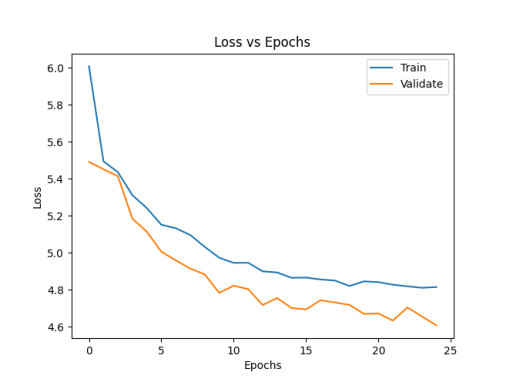

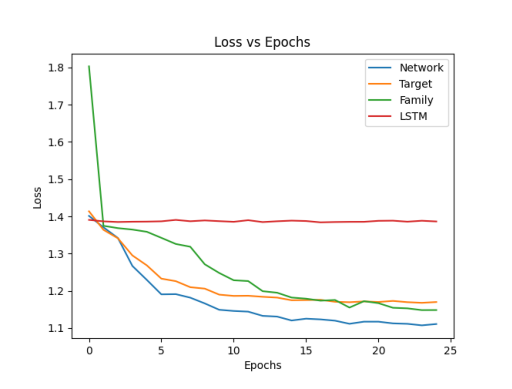

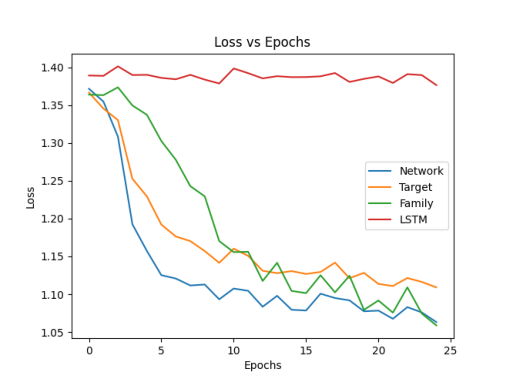

,name,GNN LSTM values
37,metric_auc_roc,0.7990347316592377
38,metric_auc_prc,0.3031034996529286
39,metric_f1,0.3487437185929648
40,metric_recall,0.7949599083619702
41,metric_mcc,0.2889537702521706
42,metric_ts,0.21119902617163724
43,metric_bss,-0.9632694122570156
44,true_negatives,4574
45,false_positives,2413
46,false_negatives,179


In [ ]:
path_25epochs = outpath + '/explainability_experiment_25epochs'
train_loss_png = mpimg.imread(path_25epochs + '/explainability_experiment_train_loss_25epochs.png')
train_seperate_loss_png = mpimg.imread(path_25epochs + '/explainability_experiment_train_separate_loss_25epochs.png')
validate_seperate_loss_png = mpimg.imread(path_25epochs + '/explainability_experiment_validate_separate_loss_25epochs.png')

plt.imshow(train_loss_png)
plt.axis('off')
plt.show()

plt.imshow(train_seperate_loss_png)
plt.axis('off')
plt.show()

plt.imshow(validate_seperate_loss_png)
plt.axis('off')
plt.show()

gnnlstm_stats = pd.read_csv(path_25epochs + '/explainability_experiment_stats_25epochs.csv').tail(11).rename(columns={'value':'GNN LSTM values'})
gnnlstm_stats

## Model comparison

The paper does ablation studies that compares its proposed model (GNN-LSTM) with various combination of features:
* [A1] 2-layer multi-layer perceptron (MLP) for age and sex features
* [A2] A1 + family history features
* [A3] A1 + graph connectivity (connected family network for the entire dataset)
* [A4] A1 + longitudinal EHR data LSTM: using a single-layer, bidirectional LSTM
* [A5] A4 + family history features
* [AG/G2] GNN-LSTM




Below is the table comparison of metric results between experiment A2: Baseline model using age, sex, and family history; experiment A5: Baseline Longitudinal model using age, sex, family history, and longitudinal data; and experiment G2: the GNN LSTM model with longitudinal data. Each model was trained for 25 epochs.

In [ ]:
baselineA2_stats = pd.read_csv(outpath + '/baselineA2_experiment_stats.csv').tail(11).rename(columns={"value":"Baseline A2 values"})
baselineA5_stats = pd.read_csv(outpath + '/baselineA5_experiment_stats.csv').tail(11).rename(columns={"value":"Baseline A5 values"})
gnnlstm_stats = pd.read_csv(path_25epochs+ '/explainability_experiment_stats_25epochs.csv').tail(11).rename(columns={'value':'GNN LSTM values'})
stats_pd = baselineA2_stats.merge(baselineA5_stats)
stats_pd = stats_pd.merge(gnnlstm_stats)
stats_pd

,name,Baseline A2 values,Baseline A5 values,GNN LSTM values
0,metric_auc_roc,0.7697122343557034,0.7662297400293886,0.7990347316592377
1,metric_auc_prc,0.27258575262294255,0.2710977441171657,0.3031034996529286
2,metric_f1,0.32305909617612977,0.3373558594797533,0.3487437185929648
3,metric_recall,0.7983963344788088,0.720504009163803,0.7949599083619702
4,metric_mcc,0.25683287517976455,0.2624770878466773,0.2889537702521706
5,metric_ts,0.19264787175234938,0.20290322580645162,0.21119902617163724
6,metric_bss,-1.1849457746274976,-1.004424517266191,-0.9632694122570156
7,true_negatives,4242,4760,4574
8,false_positives,2745,2227,2413
9,false_negatives,176,244,179


The values for the metrics AUC ROC, AUC PRC, and MCC are consistently better for the GNN-LSTM model than the other two models. This shows that GNN-LSTM is able to predict the onset of hereditary diseases better than these baseline models, with or without longitudinal data.

### Baseline
The model below is a baseline to be compared to the proposed GNN-LSTM [AG/G2]. It consists of 2-layer multi-layer perceptron that accepts various features. This model is used for experiment A1, A2, and A3.

In [ ]:
class Baseline(torch.nn.Module):
    def __init__(self, num_features_static, hidden_dim, dropout_rate):
        super().__init__()
        self.static_linear1 = nn.Linear(num_features_static, hidden_dim)
        self.static_linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.final_linear = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x_static):
        linear_out = self.relu(self.static_linear1(x_static))
        linear_out = self.relu(self.static_linear2(linear_out))
        linear_out = self.dropout(linear_out)
        out = self.sigmoid(self.final_linear(linear_out))
        return out

### Baseline Longitudinal

This baseline model is used to run experiment that includes longitudinal data, such as experiment A4 and A5.

In [ ]:
class BaselineLongitudinal(torch.nn.Module):
    def __init__(self, num_features_static, num_features_longitudinal, main_hidden_dim, lstm_hidden_dim, dropout_rate, num_lstm_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(num_features_longitudinal, lstm_hidden_dim, num_lstm_layers, batch_first=True, bidirectional=True, bias=False)
        self.lstm_hidden_dim = lstm_hidden_dim
        self.combined_linear1 = nn.Linear(num_features_static + lstm_hidden_dim*2, main_hidden_dim)
        self.combined_linear2 = nn.Linear(main_hidden_dim, main_hidden_dim)
        self.final_linear = nn.Linear(main_hidden_dim, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x_static, x_longitudinal):
        output, (hn, cn) = self.lstm(x_longitudinal)
        hn_bi = torch.cat((hn[0],hn[1]), dim=1)
        longitudinal_out = self.relu(hn_bi)
        x_cat = torch.cat((x_static, longitudinal_out), 1)
        linear_out = self.relu(self.combined_linear1(x_cat))
        linear_out = self.relu(self.combined_linear2(linear_out))
        linear_out = self.dropout(linear_out)
        out = self.sigmoid(self.final_linear(linear_out))
        return out

# Discussion

The results of our experiment show that the GNN-LSTM model is able to predict hereditary diseases in patients well. Our GNN-LSTM model produces results similar to the original paper's results. One difficulty in reproducing the experiment includes obtaining data. Although we used the provided sample synthetic dataset, we could produce more accurate results if we could obtain access to real EHR data. Despite these difficulties, the authors of the paper provided a good codebase that is well-documented and easy to follow, making it possible for us to reproduce the experiment.

Our recommendation to the original authors of this paper is to provide code for the graph representations of the GNN-LSTM explanations for parent node embeddings using clustering. This will help others to reproduce and explain the results with visualization rather than tabular data in csv format.

# References

1. Wharrie, S., Yang, Z., Ganna, A., & Kaski, S. Characterizing personalized effects of family information on disease risk using graph representation learning. Proceedings of Machine Learning Research. 2023, 219, 824-845. doi: https://arxiv.org/abs/2304.05010
2. https://github.com/dsgelab/family-EHR-graphs
3. Hamid Behravan, Jaana M Hartikainen, Maria Tengstr ̈om, Veli-Matti Kosma, and Arto
Mannermaa. Predicting breast cancer risk using interacting genetic and demographic factors
and machine learning. Scientific reports, 10(1):11044, 2020.
4. Sivan Kinreich, Jacquelyn L Meyers, Adi Maron-Katz, Chella Kamarajan, Ashwini K Pandey,
David B Chorlian, Jian Zhang, Gayathri Pandey, Stacey Subbie-Saenz de Viteri, Dan Pitti, et al. Predicting risk for alcohol use disorder using longitudinal data with multimodal biomarkers and family history: a machine learning study. Molecular psychiatry, 26(4):1133–1141, 2021.

